In [1]:
import pandas as pd
from pyspi.calculator import Calculator
import numpy as np
from copy import deepcopy
import glob
import os
import random
import neuromaps
from neuromaps.parcellate import Parcellater
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation
from pathlib import Path
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import statsmodels.stats.multitest

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in data

In [6]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in pyspi SPI info 
pyspi_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Filter to sonnet SPIs
pyspi_info_sonnet = pyspi_info.query("Sonnet=='Yes'")

# Load in all the pyspi homotopic res
all_homotopic_res = (pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
                     .merge(pyspi_info, on="SPI", how="left"))

# Filter to directed SPIs in sonnet
all_homotopic_res_directed = (all_homotopic_res.query("Directionality == 'Directed'")
                            .assign(Figure_name = lambda x: np.where(x['Figure_name'].isna(), x['SPI'], x['Figure_name']))
                              .groupby(['Subject', 'base_region_to', 'SPI', 'Figure_name'])['value']
                              .mean()
                              .reset_index()
                              )

# Only want to examine those with <10% NaN values and SD>0
all_homotopic_res_directed = all_homotopic_res_directed.groupby('SPI').filter(lambda x: x['value'].isna().mean() < 0.1)
all_homotopic_res_directed = all_homotopic_res_directed.groupby('SPI').filter(lambda x: x['value'].std() > 0)

# Compute the mean value for each base_region_to in di_gaussian_homotopic_res
all_homotopic_res_directed_mean = (all_homotopic_res_directed
                                  .groupby(["base_region_to", 'SPI', 'Figure_name'])['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region"}))


all_homotopic_res_directed_sonnet = (all_homotopic_res_directed.query("SPI in @pyspi_info_sonnet.SPI"))
all_homotopic_res_directed_sonnet_mean = (all_homotopic_res_directed_sonnet
                                  .groupby(["base_region_to", 'SPI', 'Figure_name'])['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region"}))

# Compute correlations to each neuromaps annotation of interest

In [8]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../Brain_Region_Info.csv")

# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

if not os.path.exists("all_dk_neuromaps_res.csv"):
    nm_atlas_df = pd.read_csv('neuromaps_atlases.csv')

    # Convert the DK atlas to gifti format
    dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
    dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

    # Fit a Parcellator object
    parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

    # Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
    all_dk_neuromaps_res_list = []
    for i, row in nm_atlas_df.iterrows():
        this_row_category = row['Category']
        this_row_desc = row['Description']
        source, desc, space, den = row['Filename'].split('-')

        try:
            print(f"Computing correlations for {source} {desc} {space} {den}")
            this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                                den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))
            
            # Extract this atlas' values in Desikan-Killiany space
            parc_iter = deepcopy(parc)
            this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

            # Create a dataframe
            this_atlas_data_in_dk_df = pd.DataFrame({'Category': this_row_category,
                                                        'Description': this_row_desc,
                                                        'Region_Index': range(len(this_atlas_data_in_dk)),
                                                        'Value': this_atlas_data_in_dk}).merge(brain_region_info, on="Region_Index")
            
            # Append to the list
            all_dk_neuromaps_res_list.append(this_atlas_data_in_dk_df)
        
        except Exception as e:
            print(f"Error parcellating {source} {desc} {space} {den}: {e}")
            continue

    # Concatenate all the dataframes
    all_dk_neuromaps_res = pd.concat(all_dk_neuromaps_res_list)

    # Save the results
    all_dk_neuromaps_res.to_csv("all_dk_neuromaps_res.csv", index=False)

else:
    all_dk_neuromaps_res = pd.read_csv("all_dk_neuromaps_res.csv")

all_dk_neuromaps_res_hemi_avg = all_dk_neuromaps_res.groupby(['Category', 'Description', 'Base_Region'])['Value'].mean().reset_index()

## Also compute correlation to log-weighted SC and Euclidean distance between each left--right region pair

In [9]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../Brain_Region_Info.csv")
fsaverage_data_base_path = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage"

all_centroid_res_list = []
for hemi in ["lh", "rh"]:

    # Load annotation file (parcellation)
    annot_path = f"{fsaverage_data_base_path}/{hemi}.aparc.annot"
    labels, ctab, names = fs.read_annot(annot_path)

    # Load label file (vertex coordinates)
    label_path = f"{fsaverage_data_base_path}/{hemi}.aparc.label"
    vertices = fs.read_label(label_path)

    # Load the FreeSurfer surface (to get vertex coordinates)
    pial_path = f"{fsaverage_data_base_path}/{hemi}.pial"
    surf = fs.read_geometry(pial_path)
    coords, faces = surf
    cort = np.sort(fs.read_label(f"{fsaverage_data_base_path}/{hemi}.cortex.label"))

    # Create a dictionary to store centroids
    roi_centroids = {}

    # Compute centroids for each ROI
    for i, roi_name in enumerate(names):
        roi_vertices = np.where(labels == i)[0]  # Get vertex indices in this ROI
        if len(roi_vertices) > 0:
            roi_centroids[roi_name] = coords[roi_vertices].mean(axis=0)  # Mean position

    # Convert centroids to DataFrame
    centroid_df = pd.DataFrame(roi_centroids).T
    centroid_df.columns = ["x", "y", "z"]

    # Convert names to strings, dropping corpuscallosum
    names_dec = [name.decode() for name in names if name.decode() not in ["corpuscallosum"]]

    # If centroid_df has 34 rows, drop 'unknown' from names
    if centroid_df.shape[0] == 34:
        names_dec = [name for name in names_dec if name != "unknown"]

    # Add region names and hemisphere
    centroid_df = (centroid_df.reset_index(drop=True).assign(Base_Region=names_dec, 
                                                             Hemisphere=np.where(hemi == "lh", "Left", "Right"))
                                                     .assign(Brain_Region = lambda x: hemi + '-' + x['Base_Region']))

    # Append to list
    all_centroid_res_list.append(centroid_df)

# Concatenate the results
all_centroid_res = pd.concat(all_centroid_res_list).query("Base_Region != 'unknown'")

# Compute Euclidean distances between all ROI centroids
dist_matrix = cdist(all_centroid_res[['x', 'y', 'z']], all_centroid_res[['x', 'y', 'z']], metric="euclidean")

# Convert to DataFrame
euclidean_dist_df = (pd.DataFrame(dist_matrix, index=all_centroid_res['Brain_Region'], 
                        columns=all_centroid_res['Brain_Region'])
                        .reset_index()
                        .rename(columns={"Brain_Region": "Brain_Region_From"})
                        .melt(id_vars='Brain_Region_From', var_name='Brain_Region_To', value_name='Euclidean_Distance')
                        .query("Brain_Region_From != Brain_Region_To")
                        .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.split('-').str[1],
                                Base_Region_To = lambda x: x['Brain_Region_To'].str.split('-').str[1],
                                Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.split('-').str[0]=='lh', 'Left', 'Right'),
                                Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.split('-').str[0]=='lh', 'Left', 'Right'))
                        )

# Filter to just the homotopic regions
homotopic_euclidean_dist_df = (euclidean_dist_df.query("Base_Region_From == Base_Region_To").drop_duplicates(subset=['Base_Region_To', 'Euclidean_Distance'])
                               .filter(['Base_Region_To', 'Euclidean_Distance'])
                               .rename(columns={"Base_Region_To": "Base_Region",
                                                "Euclidean_Distance": "Value"})
                               .assign(Category = "Microstructure", Description = "Euclidean Distance")
                               )

# Load in the group-averaged connectome data
homotopic_SC_dist_df = (pd.read_csv(f"{data_path}/raw_data/diffusion_MRI/aparc_HCP100_group_avg_SIFT2_consistency_75.csv",
                               header=None, 
                               names=brain_region_info.Brain_Region)
                               .assign(Brain_Region_From=brain_region_info.Brain_Region)
                               .melt(id_vars="Brain_Region_From", var_name="Brain_Region_To", value_name="SC")
                               .assign(log_SC = lambda x: np.where(x['SC'] > 0, np.log(x['SC']), 0))
                               .query("Brain_Region_From != Brain_Region_To")
                               .assign(Base_Region_From = lambda x: x.Brain_Region_From.str.replace('ctx-lh-', ''),
                                       Base_Region_To = lambda x: x.Brain_Region_To.str.replace('ctx-lh-', ''),
                                       Hemi_From = lambda x: np.where(x.Brain_Region_From.str.contains('lh'), 'Left', 'Right'),
                                       Hemi_To = lambda x: np.where(x.Brain_Region_To.str.contains('lh'), 'Left', 'Right'))
                                .assign(Base_Region_From = lambda x: x.Base_Region_From.str.replace('ctx-rh-', ''),
                                        Base_Region_To = lambda x: x.Base_Region_To.str.replace('ctx-rh-', ''))
                               .query("Base_Region_From == Base_Region_To")
                               .rename(columns={"Base_Region_From": "Base_Region"})
                               .drop_duplicates(subset=['Base_Region', 'SC', 'log_SC'])
                               .filter(['Base_Region', 'log_SC'])
                               .rename(columns={"log_SC": "Value"})
                               .assign(Category = "Microstructure", Description = "Log-SC")
)

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
all_merged_data = pd.concat([all_dk_neuromaps_res_hemi_avg, homotopic_euclidean_dist_df, homotopic_SC_dist_df])

# Iterate over SPis in all_directed_SPI_friedman_res
SPI_wise_neuromaps_corr_sonnet_list = []

for this_SPI in all_homotopic_res_directed_sonnet_mean.SPI.unique():

    # Merge the dataframes on 'Base_Region'
    this_SPI_merged_data = pd.merge(all_merged_data, all_homotopic_res_directed_sonnet_mean.query("SPI==@this_SPI"), left_on='Base_Region', right_on='Base_Region')

    # Group by 'Category' and 'Description' and compute the Spearman correlation
    spearman_corrs_di_gaussian = (this_SPI_merged_data
                                .groupby(['Category', 'Description'])
                                .apply(lambda x: spearmanr(x['Value'], x['value'])).apply(pd.Series)
                                .reset_index()
                                .assign(SPI = this_SPI))

    # Rename the columns for clarity
    spearman_corrs_di_gaussian.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

    # Append to the list
    SPI_wise_neuromaps_corr_sonnet_list.append(spearman_corrs_di_gaussian)

# Display the results
SPI_wise_neuromaps_corr_sonnet = pd.concat(SPI_wise_neuromaps_corr_sonnet_list).merge(pyspi_info, on="SPI")
SPI_wise_neuromaps_corr_sonnet['p_val_BH'] = statsmodels.stats.multitest.multipletests(SPI_wise_neuromaps_corr_sonnet.p_value, method="Holm")[1]

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_77388/758689003.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_di_gaussian = (this_SPI_merged_data
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_77388/758689003.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_di_gaussian = (this_SPI_merged_data
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipy

In [34]:
all_merged_data = pd.concat([all_dk_neuromaps_res_hemi_avg, homotopic_euclidean_dist_df, homotopic_SC_dist_df])

# Iterate over SPis in all_directed_SPI_friedman_res
SPI_wise_neuromaps_corr_list = []

for this_SPI in all_homotopic_res_directed.SPI.unique():

    # Merge the dataframes on 'Base_Region'
    this_SPI_merged_data = pd.merge(all_merged_data, all_homotopic_res_directed_mean.query("SPI==@this_SPI"), left_on='Base_Region', right_on='Base_Region')

    # Group by 'Category' and 'Description' and compute the Spearman correlation
    spearman_corrs_di_gaussian = (this_SPI_merged_data
                                .groupby(['Category', 'Description'])
                                .apply(lambda x: spearmanr(x['Value'], x['value'])).apply(pd.Series)
                                .reset_index()
                                .assign(SPI = this_SPI))

    # Rename the columns for clarity
    spearman_corrs_di_gaussian.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

    # Append to the list
    SPI_wise_neuromaps_corr_list.append(spearman_corrs_di_gaussian)

# Display the results
SPI_wise_neuromaps_corr = pd.concat(SPI_wise_neuromaps_corr_list).merge(pyspi_info, on="SPI")
SPI_wise_neuromaps_corr['p_val_BH'] = statsmodels.stats.multitest.multipletests(SPI_wise_neuromaps_corr.p_value, method="Holm")[1]

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_77388/2232856259.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_di_gaussian = (this_SPI_merged_data
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_77388/2232856259.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_di_gaussian = (this_SPI_merged_data
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/i

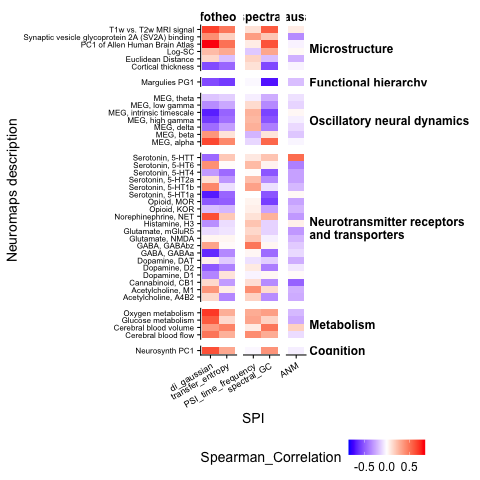

In [13]:
%%R -i SPI_wise_neuromaps_corr_sonnet

SPI_wise_neuromaps_corr_sonnet %>% 
    mutate(Category = factor(Category, levels = c("Microstructure", "Functional hierarchy", "Oscillatory neural dynamics",
                                                  "Neurotransmitter receptors and transporters",
                                                  "Metabolism",
                                                  "Development",
                                                  "Cognition")),
            Literature_category = factor(Literature_category, levels=c("infotheory", "spectral", "causal"))) %>%
    ggplot(data=., mapping=aes(x=Figure_name, y=Description, fill=Spearman_Correlation)) +
    geom_tile() +
    ylab("Neuromaps description") +
    xlab("SPI") +
    scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0, limits=c(-0.85, 0.85)) +
    facet_grid(Category ~ Literature_category, scales="free", space="free", labeller = label_wrap_gen(28)) +
    theme(axis.text.y = element_text(size=8, hjust=1),
          axis.text.x = element_text(size=9, angle=30, hjust=1),
          legend.position = "bottom",
          strip.text.x = element_text(face='bold'),
          strip.text.y = element_text(angle=0, face='bold', hjust=0),
          strip.background = element_blank()
          ) 
# ggsave("../plots/SPI_wise_neuromaps_corr_sonnet.png", width=8, height=8.5, dpi=300, units="in")

Recreate the same heatmap as above, filtering to only results with Benjamini-Hochberg P<0.05 (corrected across 39 maps * 5 SPIs = 190 comparisons)

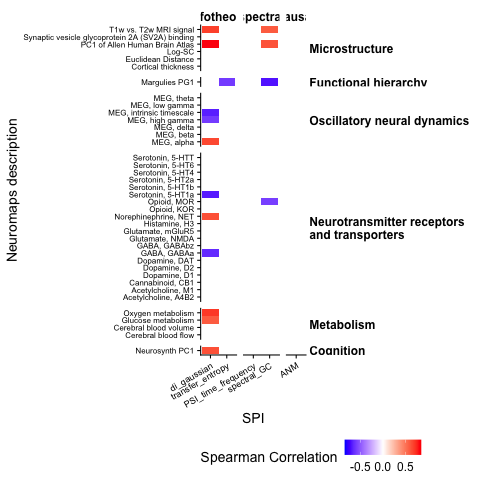

In [14]:
%%R -i SPI_wise_neuromaps_corr_sonnet

SPI_wise_neuromaps_corr_sonnet %>% 
    mutate(Category = factor(Category, levels = c("Microstructure", "Functional hierarchy", "Oscillatory neural dynamics",
                                                  "Neurotransmitter receptors and transporters",
                                                  "Metabolism",
                                                  "Development",
                                                  "Cognition")),
            Literature_category = factor(Literature_category, levels=c("infotheory", "spectral", "causal")),
            fill_val = ifelse(p_val_BH < 0.05, Spearman_Correlation, 0)) %>%
    ggplot(data=., mapping=aes(x=Figure_name, y=Description, fill=fill_val)) +
    geom_tile() +
    ylab("Neuromaps description") +
    xlab("SPI") +
    labs(fill="Spearman Correlation") +
    scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0, limits=c(-0.85, 0.85)) +
    facet_grid(Category ~ Literature_category, scales="free", space="free", labeller = label_wrap_gen(28)) +
    theme(axis.text.y = element_text(size=8, hjust=1),
          axis.text.x = element_text(size=9, angle=30, hjust=1),
          legend.position = "bottom",
          strip.text.x = element_text(face='bold'),
          strip.text.y = element_text(angle=0, face='bold', hjust=0),
          strip.background = element_blank()
          ) 
# ggsave("../plots/SPI_wise_neuromaps_corr_sonnet_sig_only.png", width=8, height=8.5, dpi=300, units="in")

### Empirically demonstrating that directed homotopic connectivity is not simply correlated with (A) physical distance between the regions or (B) structural connectivity strength between the regions

In [ ]:
merged_structural_data = pd.concat([homotopic_euclidean_dist_df, homotopic_SC_dist_df])

# Iterate over SPis in all_directed_SPI_friedman_res
SPI_wise_structural_corr_list = []

for this_SPI in all_homotopic_res_directed_mean.SPI.unique():

    # Merge the dataframes on 'Base_Region'
    this_SPI_merged_data = pd.merge(merged_structural_data, all_homotopic_res_directed_mean.query("SPI==@this_SPI"), left_on='Base_Region', right_on='Base_Region')

    # Group by 'Category' and 'Description' and compute the Spearman correlation
    spearman_corrs_di_gaussian = (this_SPI_merged_data
                                .groupby(['Category', 'Description'])
                                .apply(lambda x: spearmanr(x['Value'], x['value'])).apply(pd.Series)
                                .reset_index()
                                .assign(SPI = this_SPI))

    # Rename the columns for clarity
    spearman_corrs_di_gaussian.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

    # Append to the list
    SPI_wise_structural_corr_list.append(spearman_corrs_di_gaussian)

# Display the results
SPI_wise_structural_corr = pd.concat(SPI_wise_structural_corr_list).merge(pyspi_info, on="SPI")
SPI_wise_structural_corr['p_val_BH'] = statsmodels.stats.multitest.multipletests(SPI_wise_structural_corr.p_value, method="Holm")[1]

In [27]:
%%R -i SPI_wise_structural_corr

SPI_wise_structural_corr %>%
    mutate(SPI = fct_reorder(SPI, abs(Spearman_Correlation))) %>%
    ggplot(data=., mapping=aes(x=Description, y=SPI, fill=Spearman_Correlation)) +
    geom_tile() +
    ylab("SPI") +
    xlab("Structural description") +
    facet_grid(Literature_category~., scales='free', space='free') +
    labs(fill="Spearman Correlation") +
    ggtitle("Homotopic FC vs. Structural Properties\n[No p_BH < 0.05]") +
    scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0, limits=c(-0.85, 0.85)) +
    theme(legend.position='bottom',
          strip.text.y = element_text(angle=0, face='bold', hjust=0),
          strip.background = element_blank(),
          axis.text.y = element_text(size=7))
# ggsave("../plots/SPI_wise_structural_corrs_all_SPIs.png", width=7, height=8.5, dpi=300, units="in")

### Rank (1) SPIs by measures with which they correlate

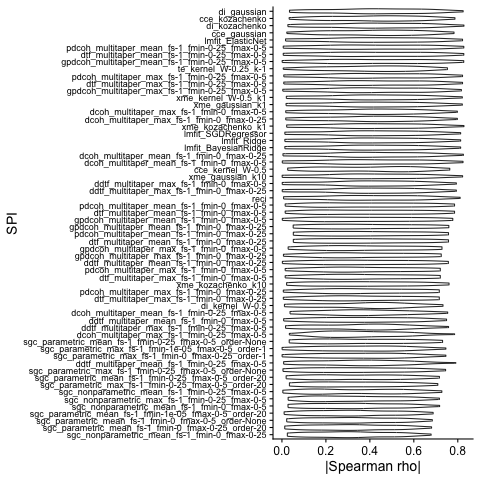

In [33]:
%%R -i SPI_wise_neuromaps_corr

SPI_wise_neuromaps_corr %>%
    group_by(SPI) %>% 
    filter(any(p_val_BH < 0.05)) %>% 
    ungroup() %>%
    mutate(Spearman_abs = abs(Spearman_Correlation)) %>%
    mutate(SPI = fct_reorder(SPI, Spearman_abs, .fun=mean)) %>%
    ggplot(data=., mapping=aes(y=SPI, x=Spearman_abs)) +
    geom_violin() +
    xlab("|Spearman rho|") +
    theme(axis.text.y = element_text(size=9))

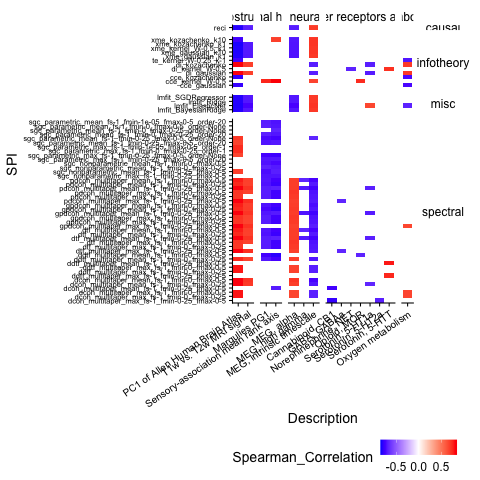

In [39]:
%%R -i SPI_wise_neuromaps_corr

SPI_wise_neuromaps_corr %>% 
    mutate(Category = factor(Category, levels = c("Microstructure", "Functional hierarchy", "Oscillatory neural dynamics",
                                                  "Neurotransmitter receptors and transporters",
                                                  "Metabolism",
                                                  "Development",
                                                  "Cognition"))) %>%
    filter(p_val_BH < 0.05) %>%
    ggplot(data=., mapping=aes(y=SPI, x=Description, fill=Spearman_Correlation)) +
    geom_tile() +
    scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0, limits=c(-0.85, 0.85)) +
    facet_grid(Literature_category ~ Category, scales="free", space="free") +
    theme(axis.text.y = element_text(size=7.5, hjust=1),
          axis.text.x = element_text(size=10, angle=35, hjust=1),
          legend.position = "bottom",
          strip.text.y = element_text(angle=0),
          strip.background = element_blank()
          ) 

### Friedman test for variance

In [35]:
%%R -i all_homotopic_res_directed -o all_directed_SPI_friedman_res

all_directed_SPI_friedman_res <- all_homotopic_res_directed %>%
    group_by(SPI) %>%
    nest() %>%
    mutate(
      test = map(data, ~ friedman.test(value ~ base_region_to | Subject, data=.x)), # S3 list-col
      tidied = map(test, tidy)
    ) %>%
    unnest(tidied) %>%
    dplyr::select(-data, -test) %>%
    ungroup() %>%
    mutate(p_value_BH = p.adjust(p.value, method="BH"))

all_directed_SPI_friedman_res %>% head()

# A tibble: 6 × 6
  SPI                            statistic   p.value parameter method p_value_BH
  <chr>                              <dbl>     <dbl>     <dbl> <chr>       <dbl>
1 anm                                 37.3 2.76e-  1        33 Fried…  2.83e-  1
2 cce_gaussian                      2906.  0                33 Fried…  0        
3 cce_kernel_W-0.5                  1993.  0                33 Fried…  0        
4 cce_kozachenko                    2853.  0                33 Fried…  0        
5 cds                                 39.1 2.14e-  1        33 Fried…  2.21e-  1
6 dcoh_multitaper_max_fs-1_fmin…     609.  4.07e-107        33 Fried…  4.83e-107
